<font size=4>Model Construction

Initially, we assume that the volume change in the rain graden is controled by several factors, which are rainfall, natural humidity, runoff, plant uptake and evaporation. Considering the availability of our collected data and for the purpose of simplifying the model calculation, we only consider evaporation as a significant term to control the volume change in the target area.<font size>


\begin{equation}
    \frac{\partial{V_{water}}}{\partial t} = \frac{\partial{V_{water\_input}}}{\partial t} - \frac{\partial{V_{water\_infiltration}}}{\partial t} - \frac{\partial{V_{water\_runoff}}}{\partial t} - \frac{\partial{V_{plant\_uptake}}}{\partial t}- \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

\begin{equation}
    \frac{\partial{V_{water}}}{\partial t} =  - \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

<font size=4>For the model, we use the low pass filter to process the data first and use the low pass filtered data into the calculation<font size>

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.fftpack import rfft, irfft, fftfreq
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [19]:
#Reading Data
Rawdata= pd.read_csv('./rgdata.csv')
Rawdata.head()

C:\Users\JyMoney\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,date,Time since start (minutes),Temperature (deg C),Humidity (%),Soil Moisture Sensor 1 (cap),Soil Moisture Sensor 2 (cap),Soil Moisture Sensor 3 (cap),Time of Day,DN,below freezing,days since start,Index overall,Inches of rain,Unnamed: 14,Sunrise,Sunset,Unnamed: 17,Unnamed: 18
0,1,11/13/2019 13:15,0.0,0.3,25.9,312,431,278,13:15,day,no,0.000000,0,0.0,NaN,6:47,16:39,NaN,NaN
1,2,11/13/2019 13:15,0.5,0.3,25.9,309,430,277,13:15,day,no,0.000347,1,0.0,NaN,NaN,NaN,NaN,NaN
2,1,11/13/2019 13:15,0.0,0.2,25.8,309,430,277,13:15,day,no,0.000000,2,0.0,NaN,NaN,0,1.0,2.0
3,2,11/13/2019 13:15,0.5,0.2,25.7,309,429,277,13:15,day,no,0.000347,3,0.0,NaN,dry,282,218.0,264.0
4,3,11/13/2019 13:16,1.0,0.1,25.9,313,434,282,13:16,day,no,0.000694,4,0.0,NaN,sat,680,874.0,1012.0


In [20]:
# Resetindex for the convenience of iteration for the model


t0=Rawdata['Time since start (minutes)']  #full time of data collection for overall trend
time1start=0
time1end=19647 #1 week of data collection to see trends from day to day
t1=Rawdata['Time since start (minutes)'].iloc[time1start:time1end]

time2start=4506
time2end=7367 #1 full day/night cycle to see trends from hour to hour
t2=Rawdata['Time since start (minutes)'].iloc[time2start:time2end]

In [21]:
dataptToShow = 'Temperature (deg C)'
originalSignal = Rawdata[dataptToShow] #entire data set

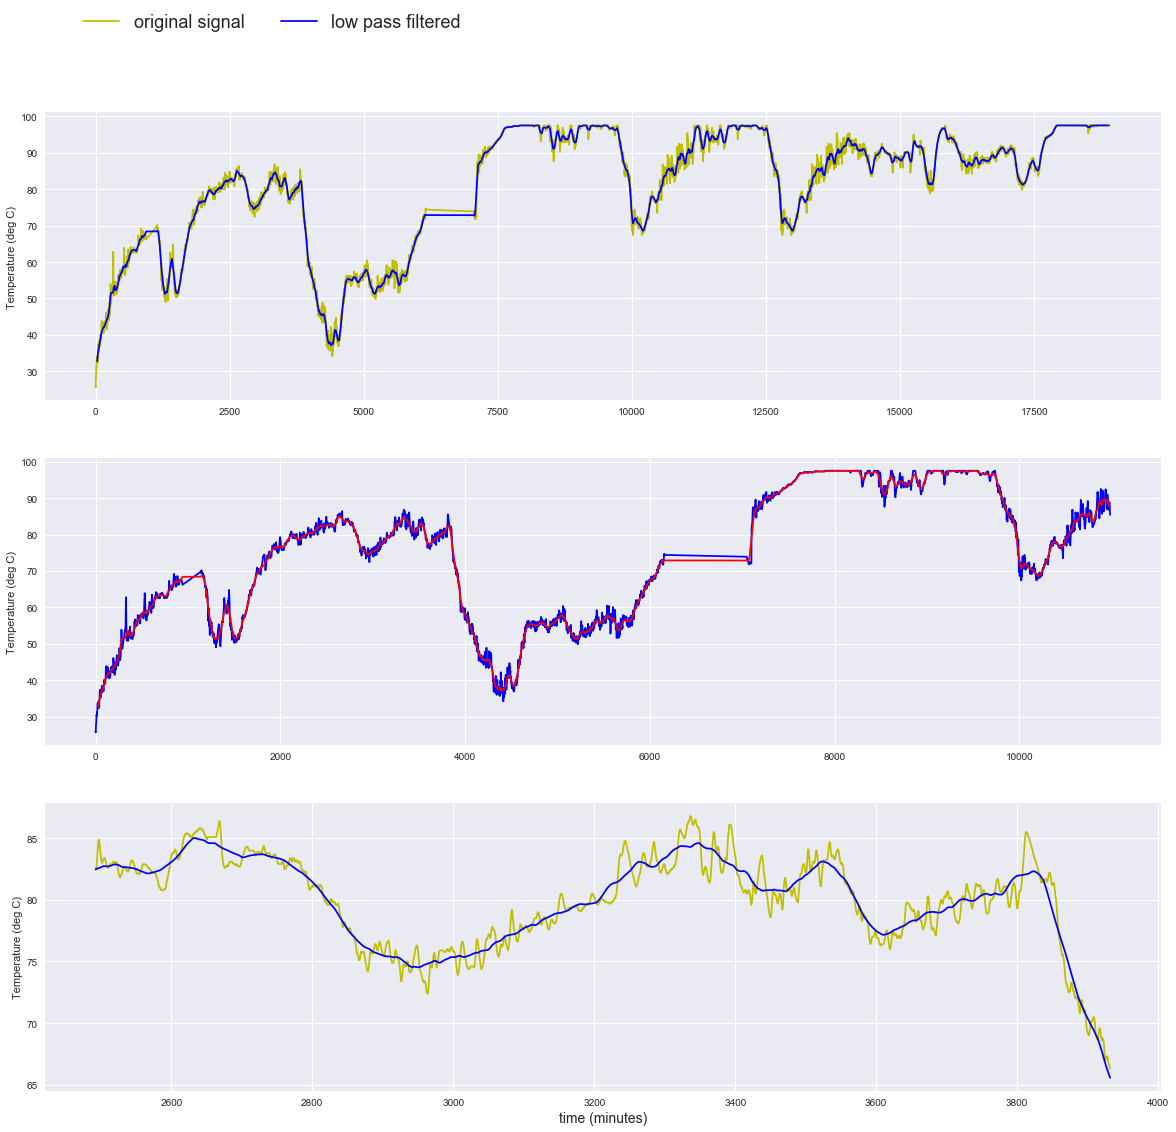

In [29]:
#Low pass filter for temperature

lowPassFilteredSignal = originalSignal.rolling(windowSize, center=True).mean()
temp_lowpass=lowPassFilteredSignal

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(20,18))
ax[0].plot(t0,originalSignal,c='y')
ax[0].plot(t0,lowPassFilteredSignal,c='b') #plots the entire data set to see overarching trends (but we only have about a week)

ax[1].plot(t1,originalSignal[time1start:time1end],c='b')
ax[1].plot(t1,lowPassFilteredSignal[time1start:time1end],c='r') #plots a week of data to see daily trends

ax[2].plot(t2,originalSignal[time2start:time2end],c='y')
ax[2].plot(t2,lowPassFilteredSignal[time2start:time2end],c='b') #plots a day of data to see hourly trends

ax[0].legend(['original signal','low pass filtered'], fontsize=18,
              loc='upper left',bbox_to_anchor=(0.02,1.4), ncol=len(lowPassFilteredSignal))
for i in range(len(ax)): ax[i].set_ylabel('Temperature (deg C)', fontsize=11)
ax[2].set_xlabel('time (minutes)', fontsize=14);

In [23]:
#Low pass filter fot the humidity
dataptToShow = 'Humidity (%)'

originalSignal = Rawdata[dataptToShow] 

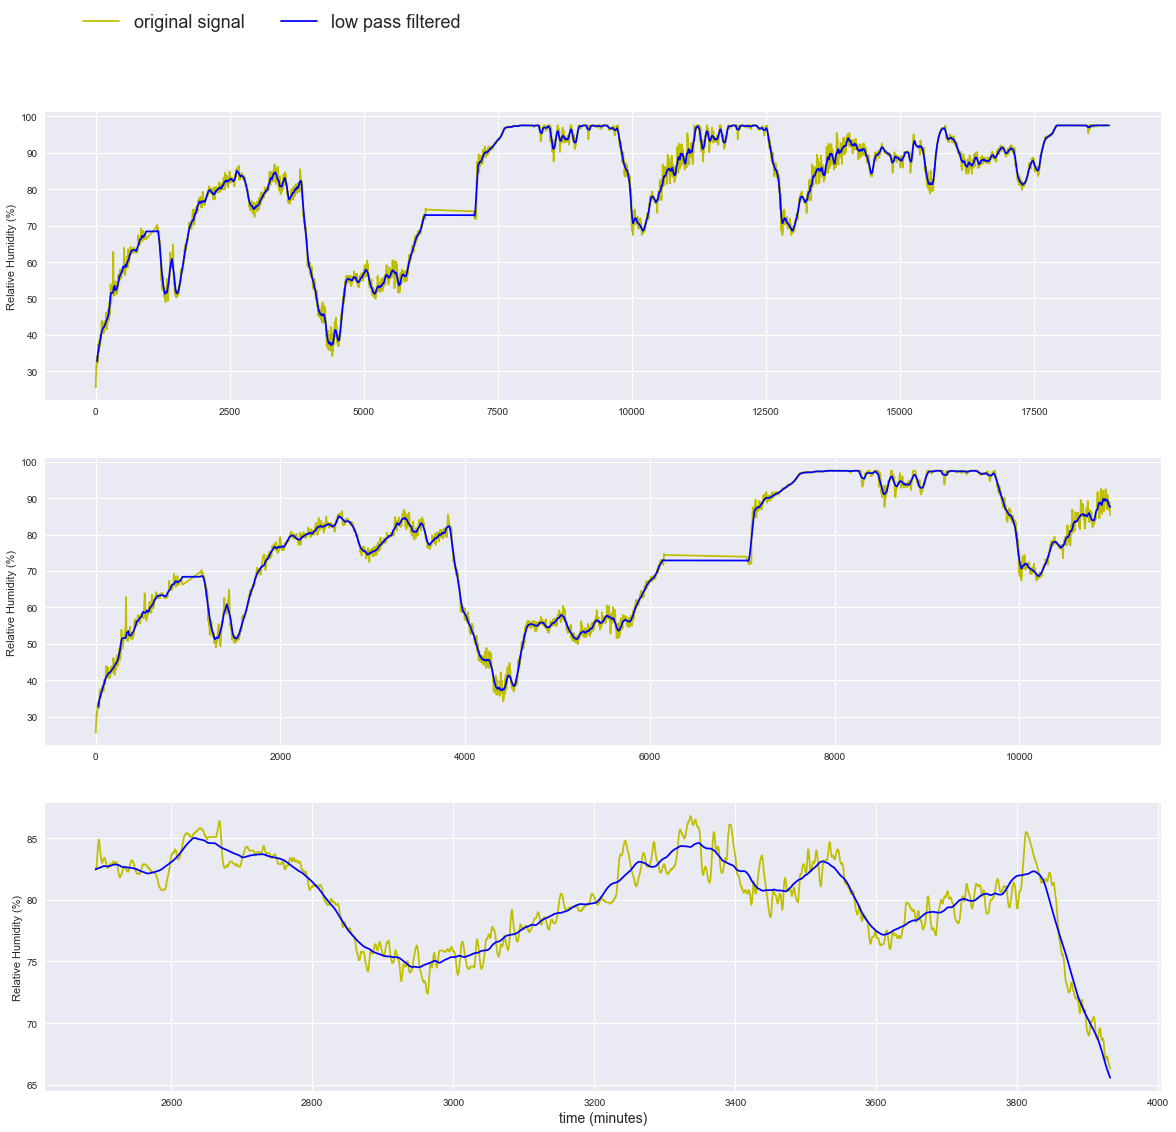

In [32]:


lowPassFilteredSignal = originalSignal.rolling(windowSize, center=True).mean()
rh_lowpass=lowPassFilteredSignal

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(20,18))
ax[0].plot(t0,originalSignal,c='y')
ax[0].plot(t0,lowPassFilteredSignal,c='b') 
ax[1].plot(t1,originalSignal[time1start:time1end],c='y')

ax[1].plot(t1,lowPassFilteredSignal[time1start:time1end],c='b') 

ax[2].plot(t2,originalSignal[time2start:time2end],c='y')
ax[2].plot(t2,lowPassFilteredSignal[time2start:time2end],c='b') 

ax[0].legend(['original signal','low pass filtered'], fontsize=18,
              loc='upper left',bbox_to_anchor=(0.02,1.4), ncol=len(lowPassFilteredSignal))
for i in range(len(ax)): ax[i].set_ylabel('Relative Humidity (%)', fontsize=11)
ax[2].set_xlabel('time (minutes)', fontsize=14);


<font size=4>Next part, we need build a new dataframe for the calculation of the model.

For our soil moisture data, since we did not find any offcial tutorial on how to transfer the data set into volum, we just take the each value as a coefficient for the volume. Besides, we assume a linear relationship between the upper and lower boundries, so we use a linear regression to transfer our reading values into volume coefficient.<font size>

In [31]:
# Before we start the calculation, set up a new data set with needed filtered data is neccessary and drop all the na values inside

Lowpassfilter=pd.DataFrame({'Time since start (minutes)': t0,
                            'Low Pass Temperature (deg C)': temp_lowpass,
                            'Low Pass Relative Humidity (%)': rh_lowpass,
                            'Low Pass Soil Moisture S1 (cap)': sms1_lowpass,
                            'Low Pass Soil Moisture S2 (cap)': sms2_lowpass,
                            'Low Pass Soil Moisture S3 (cap)': sms3_lowpass,
                            'Rain (inch)': Rawdata['Inches of rain']})

Lowpassfilter=Lowpassfilter.dropna()

In [49]:
#Reading values into coefficients by taking the highes and lowest values as boundires for 0-100 percent of saturation.
#Correspondingly, the highest reading soil moisture value is the dries condition and lowest reading is wettiest condition

# Sensor 1
Sat_cap1=680 
Dry_cap1=282
m1=(100-0)/(Sat_cap1-Dry_cap1)
b1=-m1*Dry_cap1
#Sensor 2
Sat_cap2=874
Dry_cap2=218
m2=(100-0)/(Sat_cap2-Dry_cap2)
b2=-m2*Dry_cap2
#Sensor 3               
Sat_cap3=1012
Dry_cap3=264
m3=(100-0)/(Sat_cap3-Dry_cap3)
b3=-m3*Dry_cap3

Water_coefficient1=m1*Lowpassfilter['Low Pass Soil Moisture S1 (cap)']+b1 
Water_coefficient2=m2*Lowpassfilter['Low Pass Soil Moisture S2 (cap)']+b2 
Water_coefficient3=m3*Lowpassfilter['Low Pass Soil Moisture S3 (cap)']+b3


<font size=4>Then, consider our detection depth is equal to the depth of our sensor length, so we can calculate the total volume of our soil cube. Then we can determine how much water inside the soil cube, according to the porosity. Here, assuming the porosity = 0.25.<font size>

In [50]:
#calculates percent of void spaces full of water from capacitance readings
area=1.17*4046.86 #meters
sensor_length=2.75*0.0254 #meters
vol_soil=area*sensor_length #meters cubed
porosity=0.25 #http://www.leesburgva.gov/home/showdocument?id=5057

waterVol1=Water_coefficient1*vol_soil*porosity #volume water in top few inches of basin
waterVol2=Water_coefficient2*vol_soil*porosity #volume water in top few inches of basin
waterVol3=Water_coefficient3*vol_soil*porosity #volume water in top few inches of basin



<font size=4>For the term of evaporation, serveral references on the relationships between the temperature and air humifdity were found,
 so we can use the temperature and air humidity from our reading values to determine the evaporation term.<font size>

In [51]:
time=Lowpassfilter['Time since start (minutes)']

SVP=610.7*(10**((7.5*Lowpassfilter['Low Pass Temperature (deg C)'])/(Lowpassfilter['Low Pass Temperature (deg C)']+237.3)))
VPD=(1-(Lowpassfilter['Low Pass Relative Humidity (%)']/100))*SVP/1000 #http://cronklab.wikidot.com/calculation-of-vapour-pressure-deficit
evap_constant=10 # our trial value assumed in the simulation
evap=((VPD*evap_constant)*area/1000)/(60*2*24) #meters cubed/0.5 min https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014WR015523

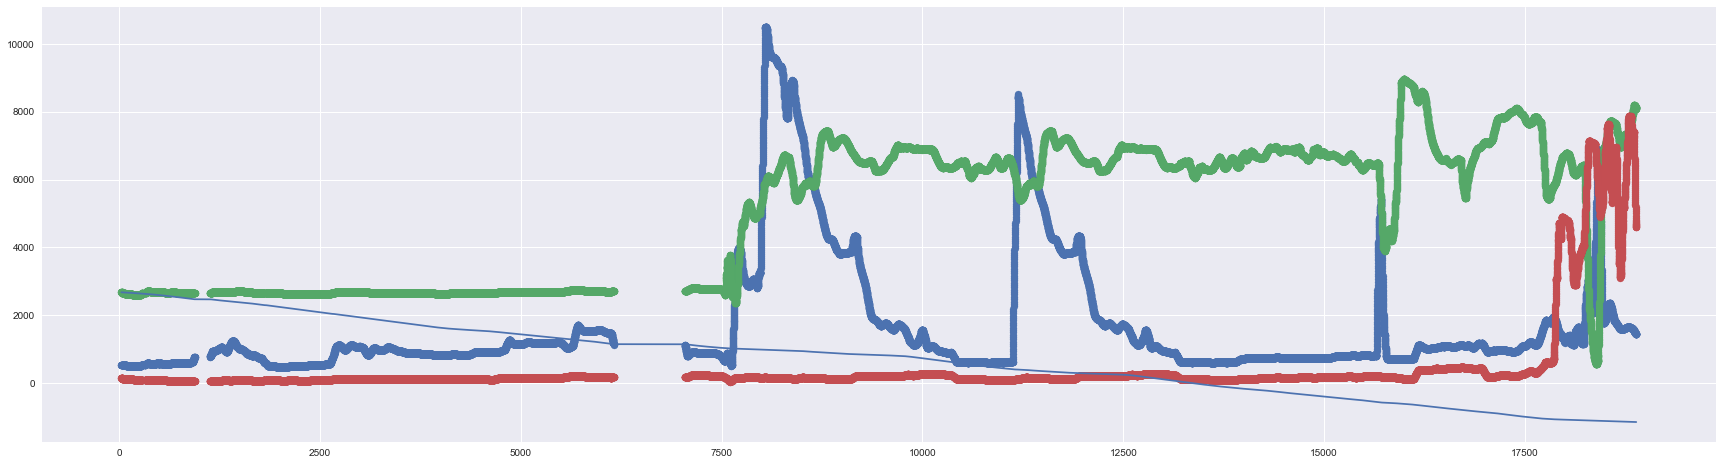

In [62]:
deltaV=-evap

initial=waterVol2.iloc[0]

timeindex=Lowpassfilter['Time since start (minutes)'].index 
#To generate model data from iterative changes
waterVol_model=np.zeros((len(deltaV),1))
waterVol_model[0]=initial+deltaV.iloc[0]
for n in range(1,len(deltaV)):
    waterVol_model[n]=waterVol_model[n-1]+deltaV.iloc[n]*(timeindex[n]-timeindex[n-1]) 
    


plt.figure(figsize = (30,8))
plt.scatter(time, waterVol1)
plt.scatter(time, waterVol2)
plt.scatter(time, waterVol3)
plt.plot(time, waterVol_model);




<font size=4>Discussion<font size>
    
   For sensor side, intially to prevent the situation that data from only one set is not reliable, meanwhile, if we can have multiple sets of sensors, we can compare each set to get a reliable range of data and normalize the data if needed. However, three sets of sensor turn out to have three trends. Apparently, the bottom line can be ignored since we have rain during the collection period, but it does not show any fluctuation and the fluctuation in the end was becasue we took out the sensor from soil. The green trend can be assumed that after the rain fall, water accumulated in the soil layers, at least the area around the sensor, and did not decrease by plantuptake infiltraton or drainage. The blue trend can be assumed a water cycle around the sensor area so we see soil moisture fluctuates two times, or becasue of some other reason.<br />
   <br />For model side, firstly, only a single and linear term is apparently not enough to simulate the actual situation and we spent lots of time in sensor setup at the beginning period but without a nice feedback. In the future work, more complex and differential term should be taken into consideraion for the model and better sensor should be selected.<br />
   <br />Finally, I really appreciate my teamates and they did a fantastic job on the project. During the discussion, I learned a bunch of hands on code skills and get to know sensor setup step by step, moreover, the tools learned in the class are really helpful and the knowlege learned in the class not only give me a glimpse into a new field for me, but also enlight my path in future study and see other possibilites. <font size>

In [ ]:
Github link: 